In [1]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import os
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
from scipy.stats import uniform,norm
import matplotlib.pyplot as plt
import scipy.stats as sct
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
#scan all the slides of one patient, load all slides, sort them in Z axis, return slice_thickness
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices

In [3]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # all data should <32k
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0

    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)

# read ct and contour image

In [4]:
INPUT_FOLDER = '../'
patients = os.listdir(INPUT_FOLDER)
print(patients)
organ=os.listdir(INPUT_FOLDER+patients[0])
print(organ)
path=INPUT_FOLDER+patients[0]+"/"+organ[0]
print(path)

['02-28-1994-CT NECK SOFT TISSUE  W CONTR-40819']
['3.000000-NeckST MPR  3.0  B30s-75963', '4.000000-NeckST MPR  3.0  B70s-75783', '602.000000-st coronals X 3s MPR Range-87966', 'assd_model.ipynb', 'Untitled.ipynb']
../02-28-1994-CT NECK SOFT TISSUE  W CONTR-40819/3.000000-NeckST MPR  3.0  B30s-75963


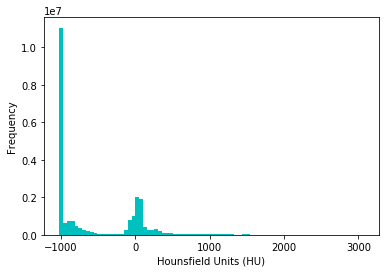

In [6]:
ct = load_scan(path)
ct_pixels = get_pixels_hu(ct)
plt.hist(ct_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

In [7]:
def sample_stack(stack, rows=5, cols=5, start_with=1, show_every=2):
    fig,ax = plt.subplots(rows,cols,figsize=[12,12])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('slice %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(stack[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

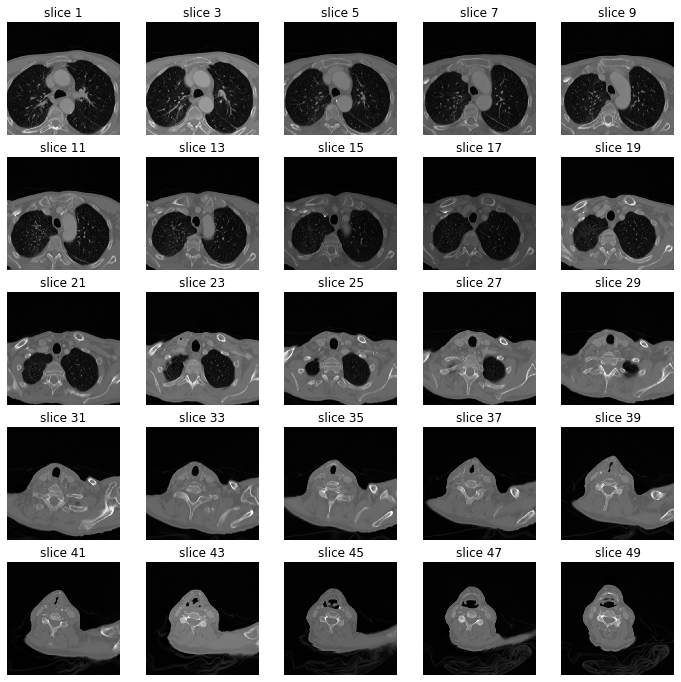

In [10]:
id=0
np.save(path + "fullimages_%d.npy" % (id), ct_pixels)

ct_image = np.load(path+'fullimages_{}.npy'.format(id))
sample_stack(ct_image)

# rescale

In [11]:
print("Slice Thickness: %f" % ct[0].SliceThickness)
print("Pixel Spacing (row, col): (%f, %f) " % (ct[0].PixelSpacing[0], ct[0].PixelSpacing[1]))

Slice Thickness: 3.000000
Pixel Spacing (row, col): (0.484375, 0.484375) 


This means we have 3.0mm slices, and each voxel represents 0.48 mm.

In [12]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + list(scan[0].PixelSpacing)))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [14]:
id = 0
ct_imgs = np.load(path+'fullimages_{}.npy'.format(id))

print("Shape before resampling\t", ct_imgs.shape)
ct_after_resamp, spacing = resample(ct_imgs, ct, [1,1,1])
print("Shape after resampling\t", ct_after_resamp.shape)

Shape before resampling	 (89, 512, 512)
Shape after resampling	 (267, 248, 248)


# 3d plotting

In [15]:
def make_mesh(image, threshold=-300, step_size=1):

    print("Transposing surface")
    p = image.transpose(2,1,0)
    
    print("Calculating surface")
    verts, faces, norm, val = measure.marching_cubes_lewiner(p, threshold, step_size=step_size, allow_degenerate=True) 
    return verts, faces
def plt_3d(verts, faces):
    print("Drawing")
    x,y,z = zip(*verts) 
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], linewidths=0.05, alpha=1)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, max(x))
    ax.set_ylim(0, max(y))
    ax.set_zlim(0, max(z))
    
    plt.show()

Transposing surface
Calculating surface
Drawing


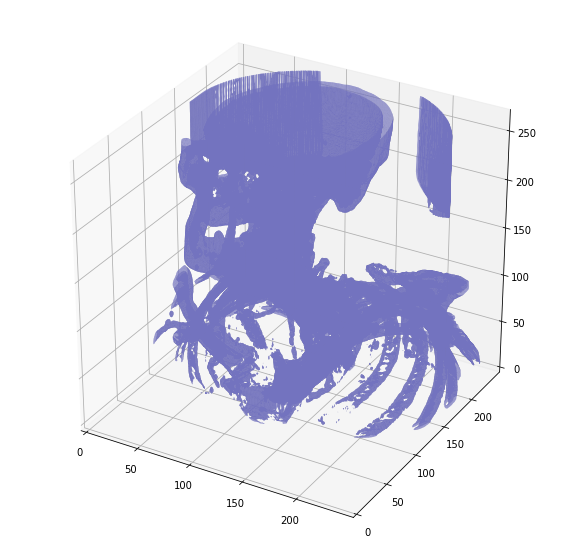

In [16]:
v, f = make_mesh(ct_after_resamp, 300)
plt_3d(v, f)

# locate contour and segment

In [17]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

In [18]:
def segment_mask(image):

    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want   
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)

    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]

    #Fill the air around the person
    binary_image[background_label == labels] = 1
    
    binary_image -= 1 #Make the image actual binary

    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0

    return binary_image

Transposing surface
Calculating surface
Drawing


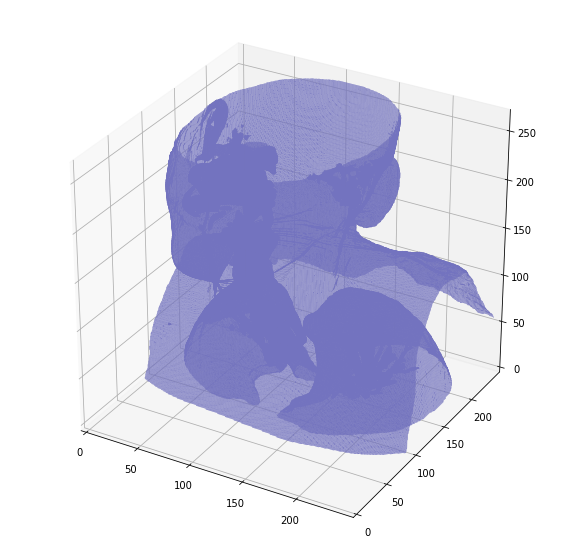

In [19]:
segmented_img2 = segment_mask(ct_after_resamp)
v, f = make_mesh(segmented_img2, 0)
plt_3d(v, f)

# apply assd model

In [22]:
def assd(slices, k, voxelsize, a, SD):
    img=slices[k]
    dim=img.shape[0]
    mat = np.ndarray([dim, dim],dtype=np.float64)
    mat[:] = 0
    for i in range(0,dim-1):
        for r in range(0,dim-1):
            pRand_k = uniform.rvs(0, 1, size = 1)
            Fsd_x=sct.norm.cdf(pRand_k, loc=0, scale=SD[0])
            Fsd_y=sct.norm.cdf(pRand_k, loc=0, scale=SD[1])
            Fsd_z=sct.norm.cdf(pRand_k, loc=0, scale=SD[2])
        
            gradct = (img[r+1,i]-img[r-1, i])/(2*voxelsize)
            Fct_r = a/(np.abs(gradct)+a)
            Fct_x =  Fct_r[0]
            Fct_y =  Fct_r[1]
            Fct_z =  Fct_r[2]
        
            D_x = Fsd_x*Fct_x
            D_y = Fsd_y*Fct_y
            D_z = Fsd_z*Fct_z
            D_r = np.array([D_x, D_y, D_z])
            D = np.linalg.norm(D_r) #cal length of vector D
            mat[r, i] = D
    
    return mat

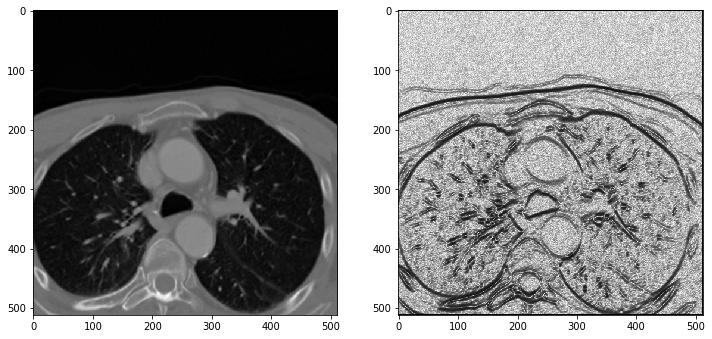

In [23]:
#before resamp
k=1
a=50
voxelsize = np.array([0.488281, 0.488281, 1])
# sd set as (1.7,2,2.5)
SD=[1.7,2,2.5]
generated=assd(ct_imgs,k,voxelsize,a,SD)
fig,(ax1, ax2) = plt.subplots(1, 2,figsize=[12,12])
ax1.imshow(ct_imgs[1],cmap="gray")
ax2.imshow(generated,cmap="gray")

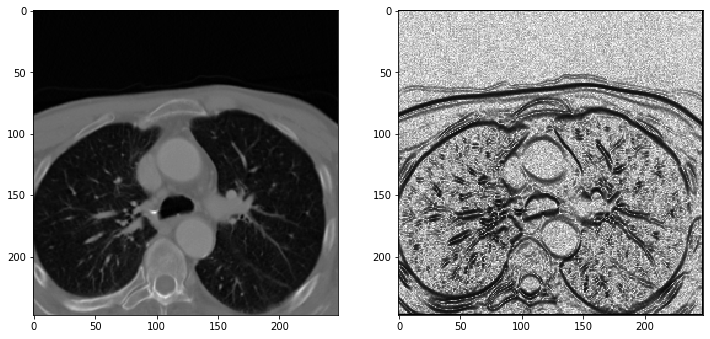

In [24]:
##after rescale
k=1
a=50
voxelsize = np.array([0.488281, 0.488281, 1])
# sd set as (1.7,2,2.5)
SD=[1.7,2,2.5]
generated2=assd(ct_after_resamp,k,voxelsize,a,SD)
fig,(ax1, ax2) = plt.subplots(1, 2,figsize=[12,12])
ax1.imshow(ct_after_resamp[1],cmap="gray")
ax2.imshow(generated2,cmap="gray")

# Q: do we need resample?will the voxel size change after resample? how to choose sd values?